Notebook for a script that will take the GHRS files from MAST and turn them into a standard spectrum fits file.

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
import astropy.constants as const
from datetime import date

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [4]:
path = '/media/david/2tb_ext_hd/hddata/ghrs_test/' #have a couple of stars in path

In [5]:
stars = os.listdir(path)

for star in stars:
    files = os.listdir('{}{}'.format(path, star))
    print(files)

['z2h00108t_ulf.fits', 'z2h00108j_jif.fits', 'z2h00108j_jit.fits', 'z2h00108t_c0f.fits', 'z2h00108t_c0f.jpg', 'z2h00108t_c1f.fits', 'z2h00108t_c2f.fits', 'z2h00108t_c3f.fits', 'z2h00108t_c4f.fits', 'z2h00108t_c5f.fits', 'z2h00108t_cqf.fits', 'z2h00108t_d0f.fits', 'z2h00108t_q0f.fits', 'z2h00108t_shf.fits', 'z2h00108t_trl.fits', 'z2h00108t_x0f.fits', 'z2h00108t_xqf.fits', 'z2h00308j_cmh.fits', 'z2h00308j_cmi.fits', 'z2h00308j_cmj.fits', 'z2h00308m_c0f.fits', 'z2h00308m_c0f.jpg', 'z2h00308m_c1f.fits', 'z2h00308m_c2f.fits', 'z2h00308m_c3f.fits', 'z2h00308m_c4f.fits', 'z2h00308m_c5f.fits', 'z2h00308m_cqf.fits', 'z2h00308m_d0f.fits', 'z2h00308m_q0f.fits', 'z2h00308m_shf.fits', 'z2h00308m_trl.fits', 'z2h00308m_ulf.fits', 'z2h00308m_x0f.fits', 'z2h00308m_xqf.fits']
['MAST_2023-01-23T18_39_42.627Z', 'MAST_2023-01-23T18_39_42.627Z.zip', 'z0ye0a08m_c0f.fits', 'z0ye0a08m_c1f.fits', 'z0ye0a08m_c2f.fits', 'z0ye0a08m_c3f.fits', 'z0ye0a08m_c4f.fits', 'z0ye0a08m_c5f.fits', 'z0ye0a0am_c0f.fits', 'z0ye0

Key calibrated files from [GHRS data handbook](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/legacy/_documents/handbooks/GHRS-data-handbook.pdf). Note there seems to have been a switch from c\*h to c\*f at some point:  
c0f = wavelength  
c1f = flux  
c2f = error  
c5f = background  
cqf = data quality flag  

Need to know what datasets are in there, group correct files, distingush between calibration files and data(?) and then make fits files. List all c0f files, then find others with that rootname? Some datasets have more than one exposure, in that case coadd them and put the subexposures in later extensions?

In [29]:
def coadd_flux(f_array, e_array, scale_correct=True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
    if scale_correct:
        error = (var * rcs)**0.5
    else:
        error = var**2
    return flux,error

eps_ind
Z2H00108T
hd209100_hrs_ech-a_z2h00108t.fits


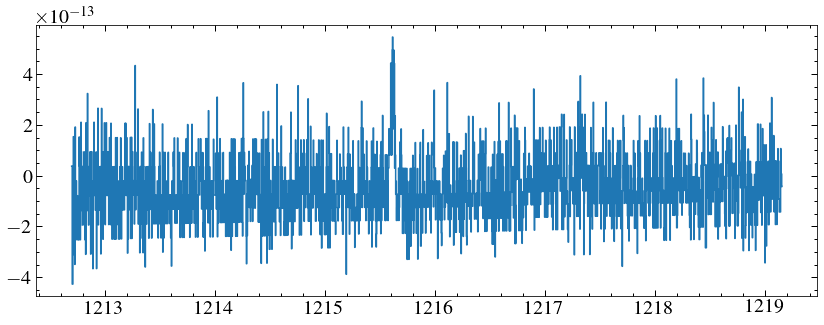

Z2H00308M
hd209100-2_hrs_ech-a_z2h00308m.fits


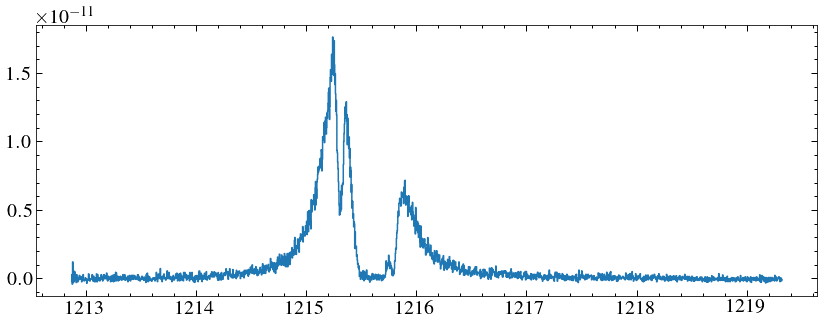

gd394
Z0YE0A08M
gd-394_hrs_g160m_z0ye0a08m.fits


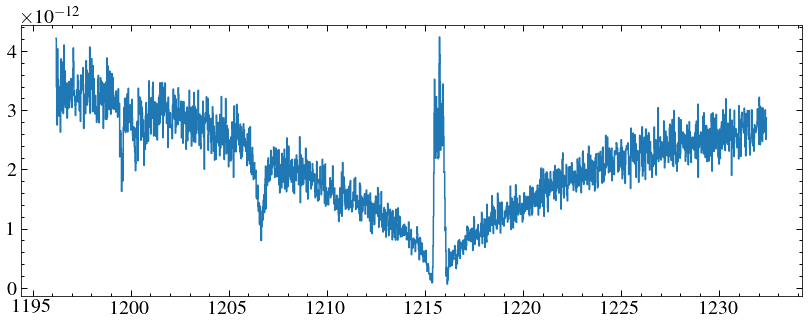

Z0YE0A0AM
gd-394_hrs_g160m_z0ye0a0am.fits


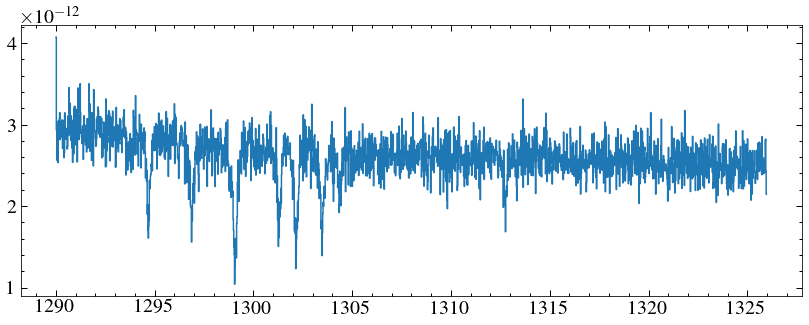

Z0YE0A0CM
gd-394_hrs_g160m_z0ye0a0cm.fits


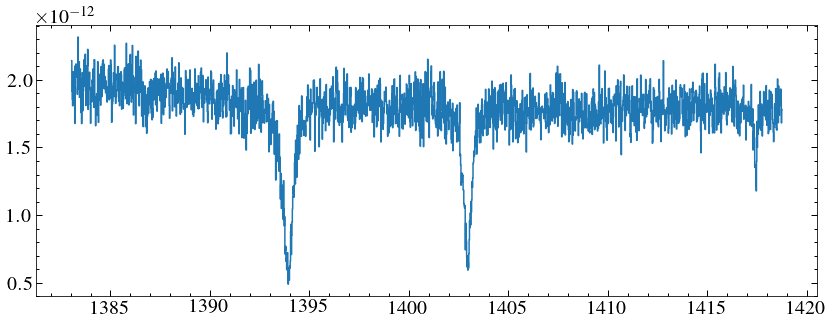

In [74]:
for star in stars:
    print(star)
    c0f_list = glob.glob('{}{}/*c0f.fits'.format(path, star))
    # print(c0f_list)
    for c0f in c0f_list:
        hdr = fits.getheader(c0f, 0)
        rootname = hdr['ROOTNAME']
        print(rootname)
        wavelength_arrays = fits.getdata(c0f, 0)
        # print(wavelength_arrays)
        c1f = '{}{}/{}_c1f.fits'.format(path, star, rootname.lower())
        flux_arrays = fits.getdata(c1f, 0)
        c2f = '{}{}/{}_c2f.fits'.format(path, star, rootname.lower())
        error_arrays = fits.getdata(c2f, 0)
        cqf = '{}{}/{}_cqf.fits'.format(path, star, rootname.lower())
        dq_arrays = fits.getdata(cqf, 0)
    
        if len(np.shape(wavelength_arrays)) == 1: #check if there are multiple subexposures that need to be combined
            wavelength, flux, error, dq = wavelength_arrays, flux_arrays, error_arrays, dq_arrays
       
        else:
            wavelength = wavelength_arrays[0] #each wavelength array in a subexposure is the same as far as I can tell
            flux, error = coadd_flux(flux_arrays, error_arrays)
            dq = [(np.sum(np.unique(dq_arrays[:,i]))) for i in range(len(dq_arrays[0]))]
        # print(dq)
        
        filename = '{}_{}_{}_{}.fits'.format(hdr['TARGNAME'].lower(), hdr['INSTRUME'].lower(), hdr['GRATING'].lower(), hdr['ROOTNAME'].lower())
        print(filename)

        data = Table((wavelength*u.AA, flux*u.erg/u.s/u.cm**2/u.AA, error*u.erg/u.s/u.cm**2/u.AA, dq), names = ['WAVELENGTH', 'FLUX', 'ERROR', 'DQ']) 
        data_ext = fits.table_to_hdu(data)
        data_ext.header.set('EXTNAME', 'SPECTRUM')
        hdr_new = hdr
        # newkeys = ['WAVEMIN', 'WAVEMAX', 'FLUXMIN', 'FLUXMAX'] #think more about this later
        # keyvals = [min(wavelength), max(wavelength), min(flux), max(flux)]
        # for key, val in zip(newkeys, keyvals):
            # hdr_new.set(key, val)
        hdr_new.set('FILENAME', filename)
        hdr_new.set('FILETYPE', 'SPECTRUM')
        hdr_new.set('FITSDATE', date.today().strftime('%Y-%m-%d'))
        primary_hdu = fits.PrimaryHDU(header=hdr_new)
        
        hdul = fits.HDUList([primary_hdu, data_ext])
        hdul.writeto('ghrs_test_fits/{}'.format(filename), overwrite=True)
        
        
        
          # BITPIX -64 -32
    # FILENAME z0ye0a0cm_cvt.c0h z0ye0a0cm_cvt.c1h
#     ALLG-MAX 1418.736 2.778947e-12
#     ALLG-MIN 1383.05 4.188579e-13
#     ODATTYPE DOUBLE FLOATING
#     DATAMIN 1383.05 4.188579e-13
#     DATAMAX 1418.736 2.778947e-12
#     FILETYPE WAV FLX
#     # BUNIT ANGSTROMS ERGS/CM**2/S/A

        
        plt.step(wavelength, flux, where='mid')
        plt.show()

Darn there are multiple exposures in each one. Ok fixed. What to do about header files?

In [51]:
hdr0 = fits.getheader(c0f, 0)
hdr1 = fits.getheader(c1f, 0)

keys0 = list(hdr0.keys())
keys1 = list(hdr1.keys())
for key in keys0:
    if key not in keys1:
        print(key, hdr0[key])
    elif hdr0[key] != hdr1[key]:
        print(key, hdr0[key], hdr1[key])

BITPIX -64 -32
FILENAME z0ye0a0cm_cvt.c0h z0ye0a0cm_cvt.c1h
ALLG-MAX 1418.736 2.778947e-12
ALLG-MIN 1383.05 4.188579e-13
ODATTYPE DOUBLE FLOATING
DATAMIN 1383.05 4.188579e-13
DATAMAX 1418.736 2.778947e-12
FILETYPE WAV FLX
BUNIT ANGSTROMS ERGS/CM**2/S/A


In [ ]:
newspecs = glob.glob('ghrs_test_fits/*.fits')

for spec in new_specs:
    data = fits.